Sample code to load the connecitvity data and cluster motor neurons.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from vnc_networks import MANC, Connections

# Define global choices

In [3]:
# Method for clustering
clustering_method = 'markov' #'hierarchical'
# distance metric
distance_metric = 'cosine_in'
# cutoff to deifne a cluster
cutoff = 0.5
# minimum number of neurons in a cluster
c_min = 4

# I. Load the data

In [ ]:
# Load the connections in the VNC from the MANC dataset
CR = MANC('v1.2') # Connectome Reader
vnc = Connections(CR = CR) # Connections object, this takes some time

Attribute class_1 not found in the graph. Adding it.


In [5]:
# Get the motor neurons for a specific leg, here the right front leg
side = 'RHS' # right hand side, can also be 'LHS'
target = 'hl' # front leg, can also be 'ml' or 'hl'

motor_neurons = vnc.get_neuron_ids( # intersection (AND) logic 
    {
        'class_1': 'motor', # class_1 is the main neuron class such as 'sensory', 'descending' etc.
        'class_2': target, # subclass, its nature depends on class_1 and dataset
        'side': side,
        }
)
print(f"Found {len(motor_neurons)} motor neurons for the {side} {target} leg")

Found 65 motor neurons for the RHS hl leg


# II. Process the data

There are two ways to work with the connections: using the Connections class, or using the Cmatrix class. 

1. The Connections class is bulky and slow, but it has a lot of information and allows to switch easily between a dataframe format, a graph format or a matrix representation. It has methods to load neuron information and filter based on any property you want.

2. The Cmatrix class has only a sparse matrix and a tabel keeping track of neuron identities as you modify the matrix. It is a lot faster computationally speaking and a lot more efficient memory-wise.

## II. A. Example using the CMatrix class

In [6]:
vnc_matrix = vnc.get_cmatrix(type_='unnorm') # the weights are the signed synapse counts, no normalisation is done

In [7]:
# Cut it down to the motor and premotor connections
premotor_neurons = vnc_matrix.list_upstream_neurons(motor_neurons)
nodes = list(set(motor_neurons).union(premotor_neurons))
vnc_matrix.restrict_nodes(nodes)

In [8]:
# cluster the motor neurons using cosine similarity on the inputs
# Clustering
(
    clustered_cmatrix,  # clustered similarity matrix as cmatrix object
    uid_clusters,  # list of lists of uids in each cluster
    index_clusters,  # list of lists of indices in each cluster matching the clustered cmatrix
) = vnc_matrix.detect_clusters(
    distance=distance_metric,
    method=clustering_method,
    cutoff=cutoff,
    cluster_size_cutoff=c_min,
    cluster_data_type="uid",
    cluster_on_subset=motor_neurons,
)
print(uid_clusters)
print(index_clusters)


[[53, 729, 5299, 19057, 19282], [236, 2738, 4452, 5236, 8886, 10545, 17652, 19536, 20640], [615, 2301, 2399, 4033, 4146, 7885, 9546, 16377, 17832, 22504], [638, 1215, 4042, 4481, 5669, 7545, 10906, 14269, 17104, 19671], [1516, 1725, 2369, 2421, 5019, 7155, 11438, 12567, 13631, 15301, 18958], [3251, 3852, 3931, 5456, 8784, 12786, 12789, 16421, 16772, 18741, 20299, 23053]]
[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9, 10, 11, 12, 13], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]]


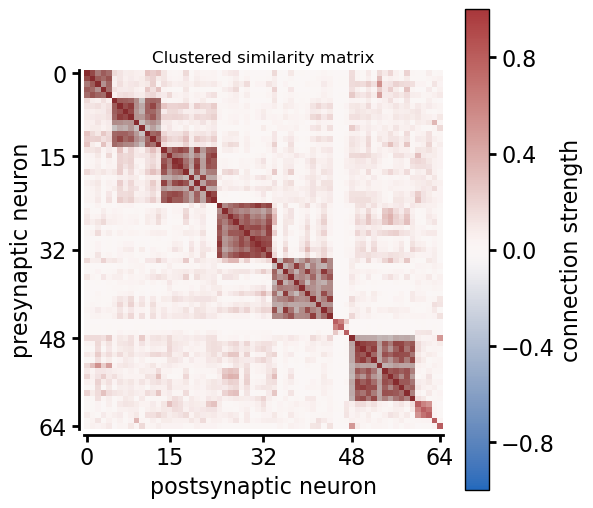

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
# Visualise the similarity matrix and its clusters
clustered_sim_mat = clustered_cmatrix.get_matrix().todense()
# create a matrix of zeros
mat = np.zeros((clustered_sim_mat.shape[0], clustered_sim_mat.shape[1]))
# draw the boundaries between clusters
for cluster in index_clusters:
    mat[cluster[0] : cluster[-1] + 1, cluster[0] : cluster[-1] + 1] = 1
_ = clustered_cmatrix.imshow(savefig=False, ax=ax, title="Clustered similarity matrix")
ax.imshow(mat, cmap="binary", alpha=0.2)
plt.show()

## II. B. Example using the Connections class

In [10]:
# Find an interesting input to a network, here a group of descendign neurons named MDN
input_neurons = vnc.get_neuron_ids(
    {
        'class_1' : 'descending', # descending neuron
        'type': 'MDN', # a specific name
    }
)

In [11]:
# Keep only the connections that create a path from source to target
subnetwork = vnc.subgraph_from_paths( # copy operation
    source = input_neurons,
    target = motor_neurons,
    n_hops = 2, # within 2 hops, i.e. only 1 interneuron
    keep_edges = 'intermediate', # keep the connections between the interneurons
    # as well, but not between source neurons or between target neurons
    # can also be 'direct' (only direct paths) or 'all' (all connections between
    # recruited nodes)
)

Attribute class_1 not found in the graph. Adding it.


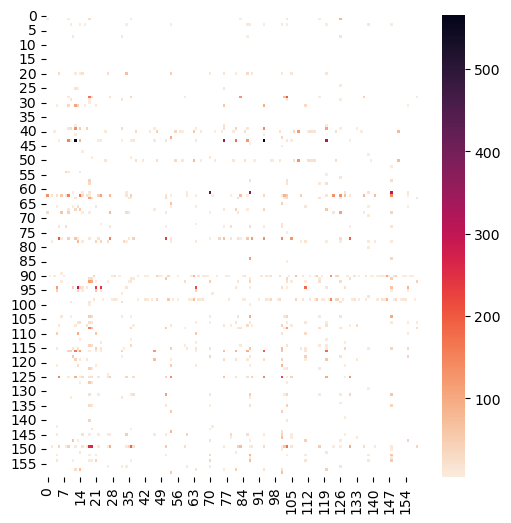

In [12]:
# Visualise the result as a matrix
fig, ax = plt.subplots(figsize=(6, 6))
subnetwork.display_adjacency_matrix(
    method = 'heatmap',
    save = False,
    ax=ax,
)
plt.show()

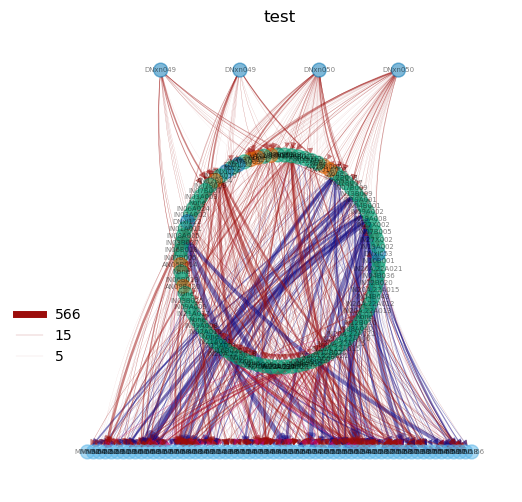

In [13]:
# Visualise the result as a graph
fig, ax = plt.subplots(figsize=(6,6))
subnetwork.draw_graph_in_out_center_circle( # there are other graph visualisation options as well
    input_nodes = input_neurons,
    output_nodes = motor_neurons,
    syn_threshold = None, # you can put a number to cut off weak connections
    label_nodes = True,
    save = False,
    ax=ax,
    )
plt.show()

## II. C. Repeat clustering but with the DN input as prior

In [14]:
subnetwork_matrix = subnetwork.get_cmatrix(type_="unnorm")
# Cut it down to the motor and premotor connections
premotor_neurons = subnetwork_matrix.list_upstream_neurons(motor_neurons)
nodes = list(set(motor_neurons).union(premotor_neurons))
subnetwork_matrix.restrict_nodes(nodes)

In [15]:
# cluster the motor neurons using cosine similarity on the inputs
# Clustering
(
    sub_clustered_cmatrix,  # clustered similarity matrix as cmatrix object
    sub_uid_clusters,  # list of lists of uids in each cluster
    sub_index_clusters,  # list of lists of indices in each cluster matching the clustered cmatrix
) = subnetwork_matrix.detect_clusters(
    distance=distance_metric,
    method=clustering_method,
    cutoff=cutoff,
    cluster_size_cutoff=c_min,
    cluster_data_type="uid",
    cluster_on_subset=motor_neurons,
)

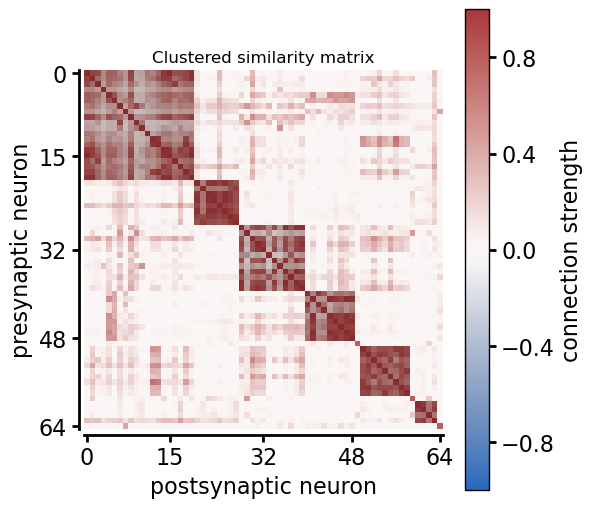

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
# Visualise the similarity matrix and its clusters
sub_clustered_sim_mat = sub_clustered_cmatrix.get_matrix().todense()
# create a matrix of zeros
mat = np.zeros((sub_clustered_sim_mat.shape[0], sub_clustered_sim_mat.shape[1]))
# draw the boundaries between clusters
for cluster in sub_index_clusters:
    mat[cluster[0] : cluster[-1] + 1, cluster[0] : cluster[-1] + 1] = 1
_ = sub_clustered_cmatrix.imshow(savefig=False, ax=ax, title="Clustered similarity matrix")
ax.imshow(mat, cmap="binary", alpha=0.2)
plt.show()